In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
df = pd.read_csv('regression_data.csv')
df.head(3)

,x,y
0,0.047159,0.220033
1,0.064022,0.179399
2,0.080122,0.195405


In [42]:
PHI = df['x'].to_numpy().reshape(-1, 1)
PHI = np.hstack([
    PHI,
    np.ones(PHI.shape)
])
T = df['y'].to_numpy().reshape(-1, 1)

PHI.shape, T.shape

((116, 2), (116, 1))

In [43]:
inv = np.linalg.inv

In [37]:
W = inv(PHI.T @ PHI) @ PHI.T @ T
W

array([[0.62016068],
       [0.28106931]])

In [40]:
x_min, x_max = PHI.min(), PHI.max()
xs = np.arange(x_min, x_max, 0.01)
ys = float(W[0]) * xs + float(W[1])

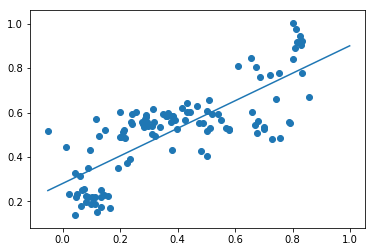

In [41]:
plt.scatter(PHI[:,0], T)
plt.plot(xs, ys)
plt.show()